In [165]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from pathlib import Path
from dataclasses import dataclass

In [166]:
sns.set_theme(style="whitegrid", rc={"figure.figsize": (8, 4)})

DPI_EXPORT = 600
ASSIGNMENT_DIR = Path().resolve()
OUTPUT_DIR = ASSIGNMENT_DIR / "output"

## 1.4

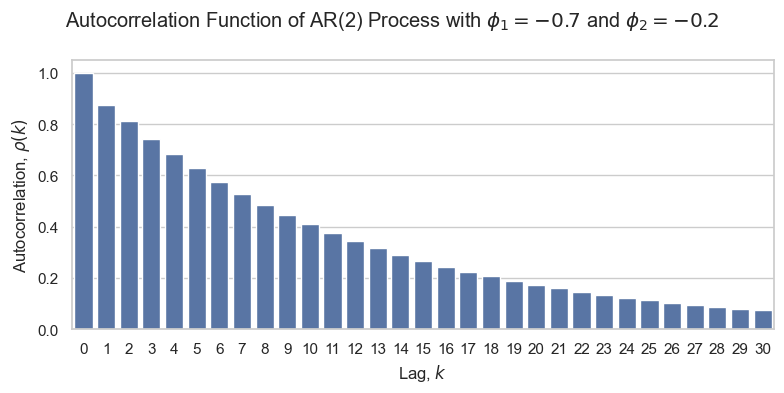

In [167]:
phi_1 = -0.7
phi_2 = -0.2

rhos = [1, -phi_1 / (1 + phi_2)]
for k in range(2, 30 + 1):
    rhos.append(-phi_1 * rhos[k - 1] - phi_2 * rhos[k - 2])

df_rhos = pd.DataFrame(rhos, columns=["rho"])
df_rhos["k"] = df_rhos.index
df_rhos

plt.figure()
sns.barplot(df_rhos, x="k", y="rho")
plt.xlabel("Lag, $k$")
plt.ylabel("Autocorrelation, $ρ(k)$")
plt.suptitle("Autocorrelation Function of AR(2) Process with $ϕ_1=-0.7$ and $ϕ_2=-0.2$")
plt.tight_layout()
plt.savefig(OUTPUT_DIR / "1_4_autocorrelation_function.png", dpi=DPI_EXPORT)

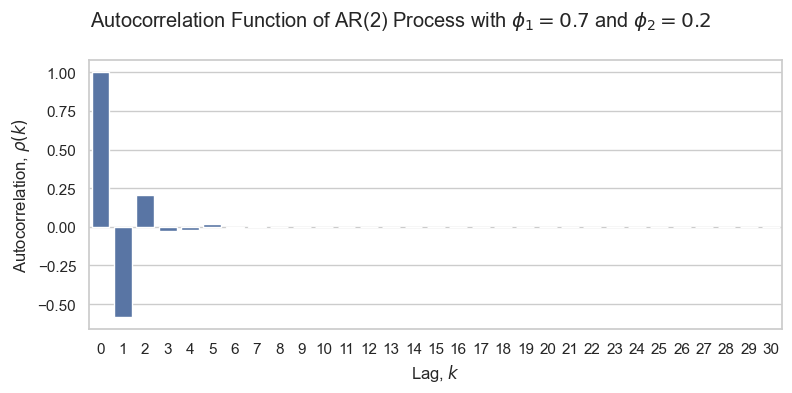

In [168]:
phi_1 = 0.7
phi_2 = 0.2

rhos = [1, -phi_1 / (1 + phi_2)]
for k in range(2, 30 + 1):
    rhos.append(-phi_1 * rhos[k - 1] - phi_2 * rhos[k - 2])

df_rhos = pd.DataFrame(rhos, columns=["rho"])
df_rhos["k"] = df_rhos.index
df_rhos

plt.figure()
sns.barplot(df_rhos, x="k", y="rho")
plt.xlabel("Lag, $k$")
plt.ylabel("Autocorrelation, $ρ(k)$")
plt.suptitle("Autocorrelation Function of AR(2) Process with $ϕ_1=0.7$ and $ϕ_2=0.2$")
plt.tight_layout()
plt.savefig(OUTPUT_DIR / "1_4_autocorrelation_function_incorrect.png", dpi=DPI_EXPORT)

Ellipsis

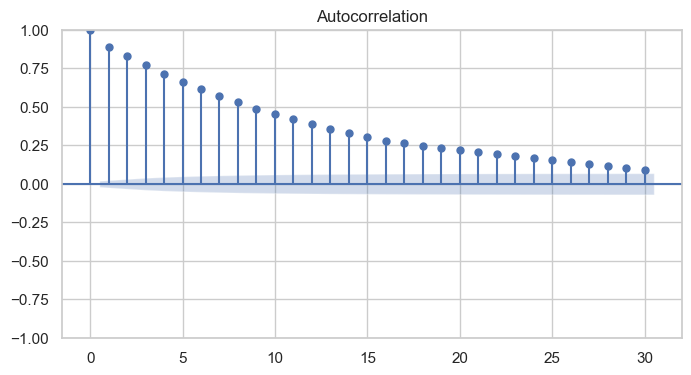

In [169]:
# To prove to myself that first plot is correct with respect to assignment description
phi_1 = -0.7
phi_2 = -0.2
N = 10000
epsilon = np.random.normal(size=(N,))
y = np.zeros(N)
for t in range(2, N):
    y[t] = -phi_1 * y[t - 1] + -phi_2 * y[t - 2] + epsilon[t]

plot_acf(y, lags=30)
...

# 2

In [170]:
@dataclass
class ModelParams:
    p: int
    d: int
    q: int
    P: int
    D: int
    Q: int
    s: int

    phis: list[float]
    Phis: list[float]
    thetas: list[float]
    Thetas: list[float]

    var: float

    def to_params(self):
        """
        Convert the model parameters to a list of parameters for the SARIMAX model.
        """
        params = []
        params.extend(self.phis)
        params.extend(self.thetas)
        params.extend(self.Phis)
        params.extend(self.Thetas)
        params.append(self.var)

        assert len(params) == self.p + self.q + self.P + self.Q + 1
        return params

    def to_model(self):
        pdq = (self.p, self.d, self.q)
        seasonal_PDQs = (self.P, self.D, self.Q, self.s)

        return SARIMAX(
            [],
            order=pdq,
            seasonal_order=seasonal_PDQs,
        )

    @classmethod
    def from_weights(
        cls,
        phis: list[float] | None = None,
        thetas: list[float] | None = None,
        Phis: list[float] | None = None,
        Thetas: list[float] | None = None,
        d: int = 0,
        D: int = 0,
        s: int = 0,
        var: float = 1.0,
    ):
        """
        Create a ModelParameters instance from a list of parameters.
        """
        if phis is None:
            phis = []
        if thetas is None:
            thetas = []
        if Phis is None:
            Phis = []
        if Thetas is None:
            Thetas = []

        p = len(phis)
        q = len(thetas)
        P = len(Phis)
        Q = len(Thetas)

        return cls(
            p=p,
            d=d,
            q=q,
            P=P,
            D=D,
            Q=Q,
            s=s,
            phis=phis,
            Phis=Phis,
            thetas=thetas,
            Thetas=Thetas,
            var=var,
        )


def plotter(df, params, *, title, n_lags=30):
    """
    Plot the simulated data from a SARIMAX model using a 2-column layout.

    Parameters:
    - model: SARIMAX model instance
    - params: list of parameters for the model
    - n: number of observations to simulate
    - title: title for the overall figure
    """
    # Create a 2×1+1×2 subplot layout
    fig, axes = plt.subplot_mosaic([["ts", "ts"], ["acf", "pacf"]], figsize=(10, 5))

    param_desc = f"(p, d, q) = ({params.p}, {params.d}, {params.q})"
    param_desc += (
        f"\\quad (P, D, Q)_s = ({params.P}, {params.D}, {params.Q})_{{{params.s}}}"
    )
    weights = []
    weights.extend([f"ϕ_{i + 1} = {params.phis[i]}" for i in range(0, params.p)])
    weights.extend([f"θ_{i + 1} = {params.thetas[i]}" for i in range(0, params.q)])
    weights.extend([f"Φ_{i + 1} = {params.Phis[i]}" for i in range(0, params.P)])
    weights.extend([f"Θ_{i + 1} = {params.Thetas[i]}" for i in range(0, params.Q)])
    weights.append(f"σ^2 = {params.var}")

    param_desc += f"\\quad {', '.join(weights)}"
    param_desc = "$" + param_desc + "$"
    title += "\n" + param_desc
    fig.suptitle(title, fontsize=14)

    # Time series
    sns.lineplot(df, x="t", y="y", ax=axes["ts"])
    # axes["ts"].set_title("Time Series")
    axes["ts"].set_xlabel("Discretised Time, $t$")
    axes["ts"].set_ylabel("Observation, $y_t$")

    # ACF plot
    plot_acf(df["y"], lags=n_lags, ax=axes["acf"], alpha=0.05)
    axes["acf"].set_title("Autocorrelation")
    axes["acf"].set_xlabel("Lag, $k$")
    axes["acf"].set_ylabel("$ρ(k)$")

    # PACF plot
    plot_pacf(
        df["y"], lags=n_lags, ax=axes["pacf"], alpha=0.05, zero=False, auto_ylims=True
    )
    axes["pacf"].set_title("Partial Autocorrelation")
    axes["pacf"].set_xlabel("Lag, $k$")
    axes["pacf"].set_ylabel("$φ(k)$")

    plt.tight_layout()
    plt.subplots_adjust(top=0.87)  # Make room for the title
    return fig, axes


def make_data(params, n=1000, burn_in=1000):
    """
    Create a SARIMAX model and simulate data.
    """

    model = params.to_model()
    # print(model.param_names)

    # Simulate data
    t = np.arange(n)
    y = model.simulate(params.to_params(), n + burn_in)[burn_in:]

    return pd.DataFrame({"y": y, "t": t})


def make_and_plot(params, n=1000, title="SARIMAX Model Simulation", n_lags=30):
    """
    Create and plot a SARIMAX model with the given parameters.
    """
    df = make_data(params, n)
    fig, axes = plotter(df, params, title=title, n_lags=n_lags)
    return fig
    # plt.savefig(OUTPUT_DIR / f"1_4_{pdq}_{seasonal_PDQs}.png", dpi=DPI_EXPORT)


Ellipsis

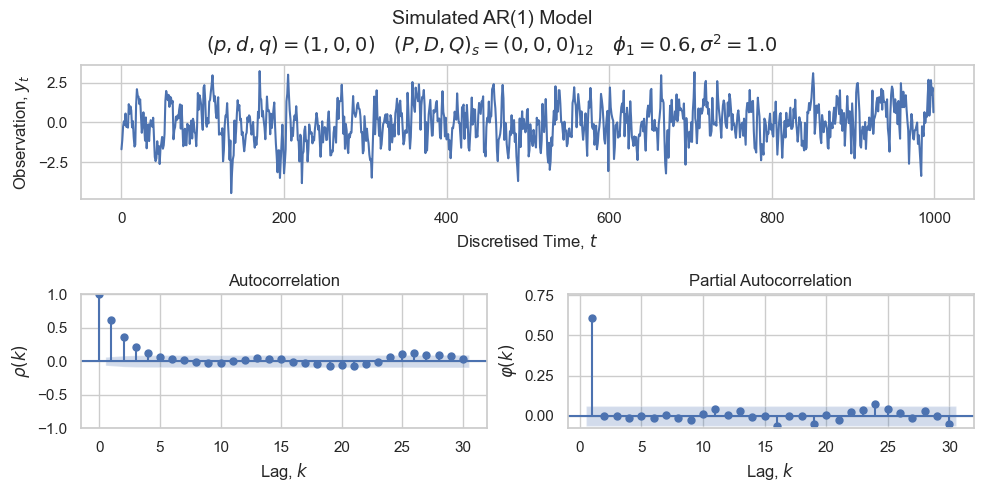

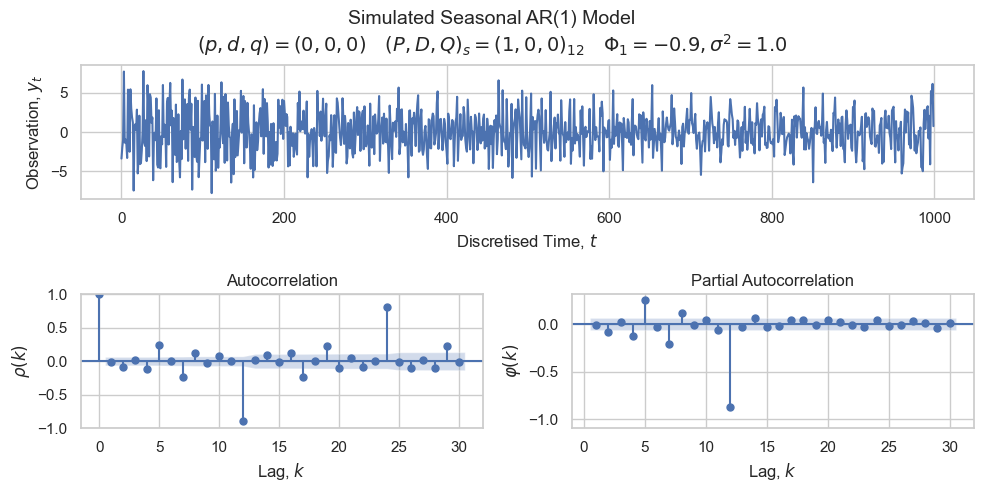

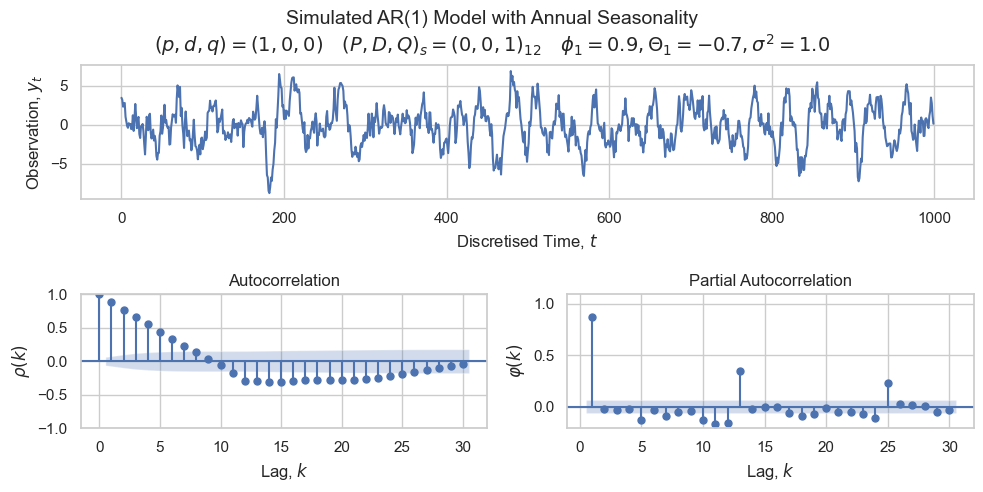

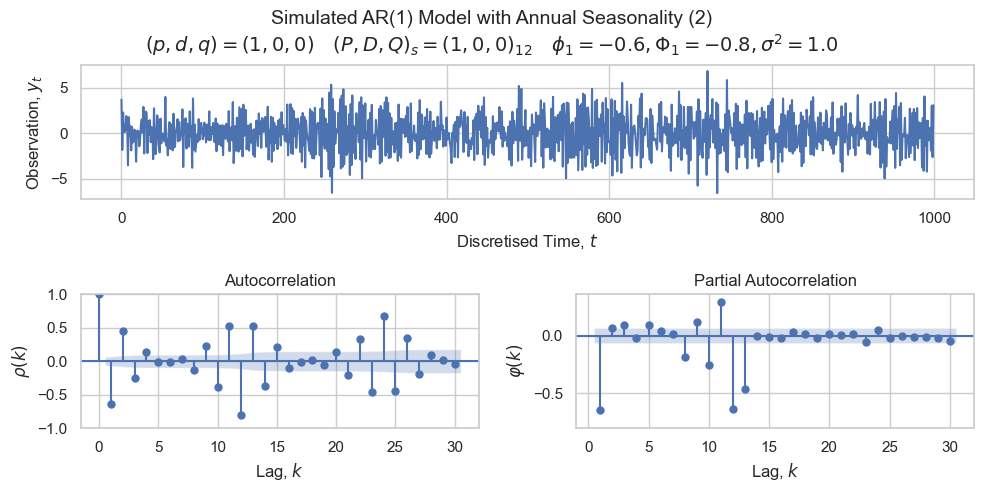

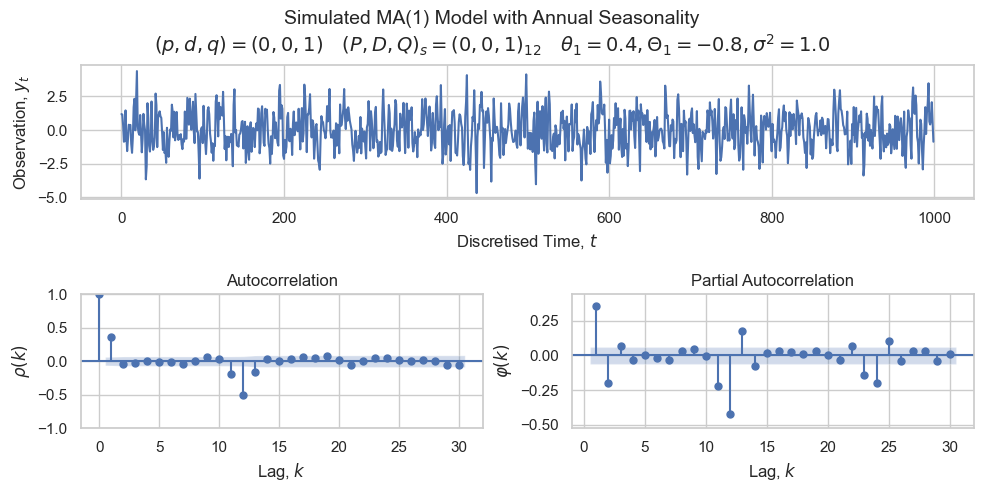

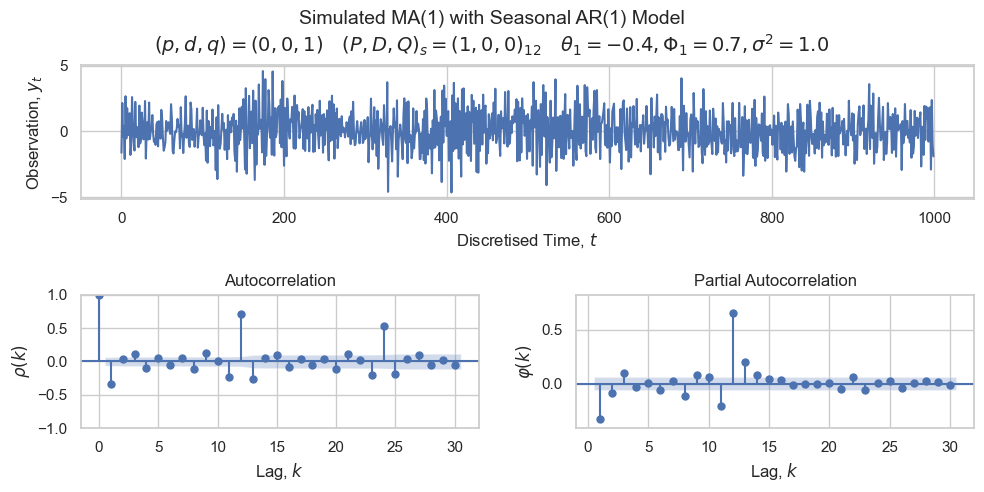

In [171]:
make_and_plot(
    ModelParams.from_weights(phis=[0.6], s=12), n=1000, title="Simulated AR(1) Model"
)
make_and_plot(
    ModelParams.from_weights(Phis=[-0.9], s=12),
    n=1000,
    title="Simulated Seasonal AR(1) Model",
)
make_and_plot(
    ModelParams.from_weights(phis=[0.9], Thetas=[-0.7], s=12),
    n=1000,
    title="Simulated AR(1) Model with Annual Seasonality",
)
make_and_plot(
    ModelParams.from_weights(phis=[-0.6], Phis=[-0.8], s=12),
    n=1000,
    title="Simulated AR(1) Model with Annual Seasonality (2)",
)

make_and_plot(
    ModelParams.from_weights(thetas=[0.4], Thetas=[-0.8], s=12),
    n=1000,
    title="Simulated MA(1) Model with Annual Seasonality",
)

make_and_plot(
    ModelParams.from_weights(thetas=[-0.4], Phis=[0.7], s=12),
    n=1000,
    title="Simulated MA(1) with Seasonal AR(1) Model",
)
...

# 3

https://www.kaggle.com/code/iamleonie/time-series-interpreting-acf-and-pacf

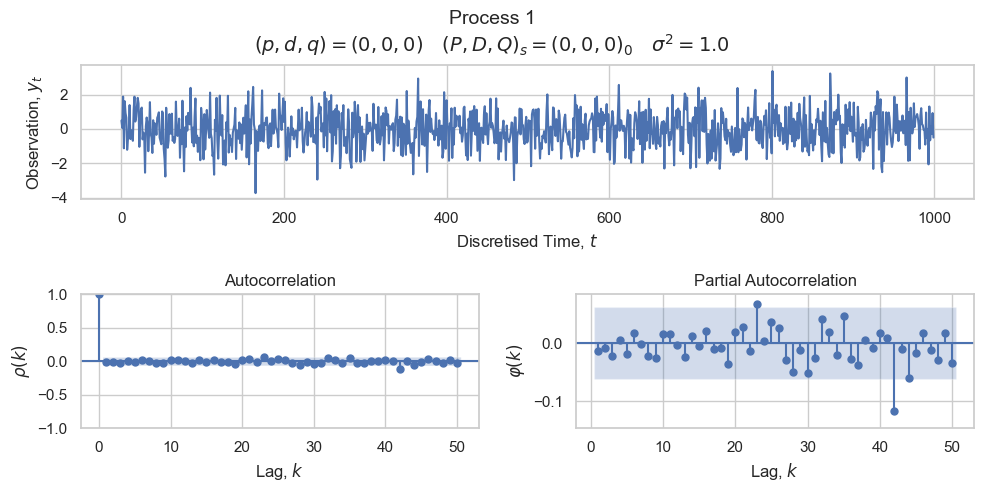

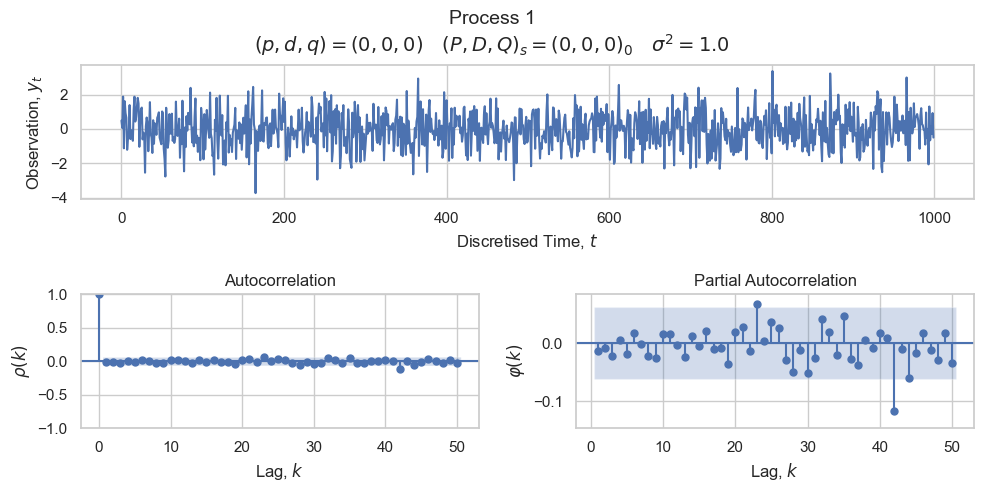

In [172]:
## 3.1
make_and_plot(
    ModelParams.from_weights(),
    n=1000,
    title="Process 1",
    n_lags=50,
)

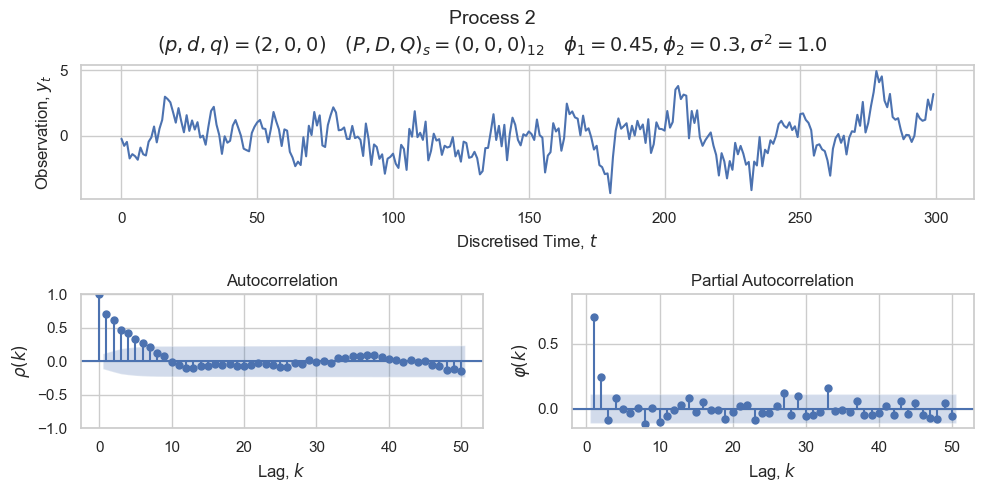

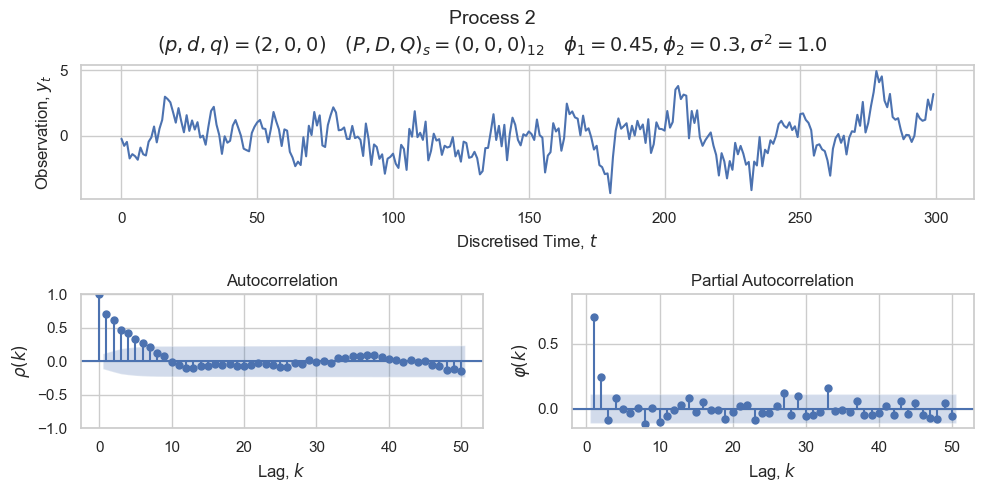

In [173]:
## 3.2

make_and_plot(
    ModelParams.from_weights(phis=[0.45, 0.3], s=12),
    n=300,
    title="Process 2",
    n_lags=50,
)

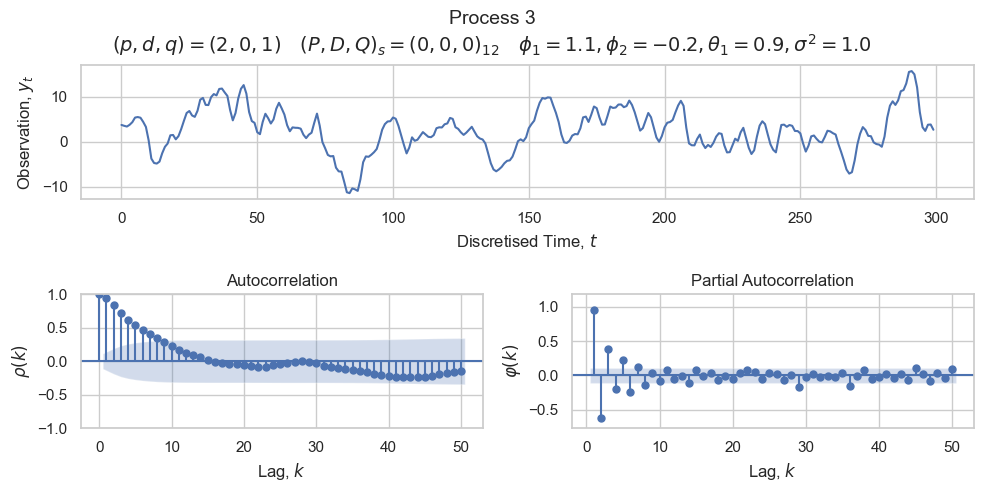

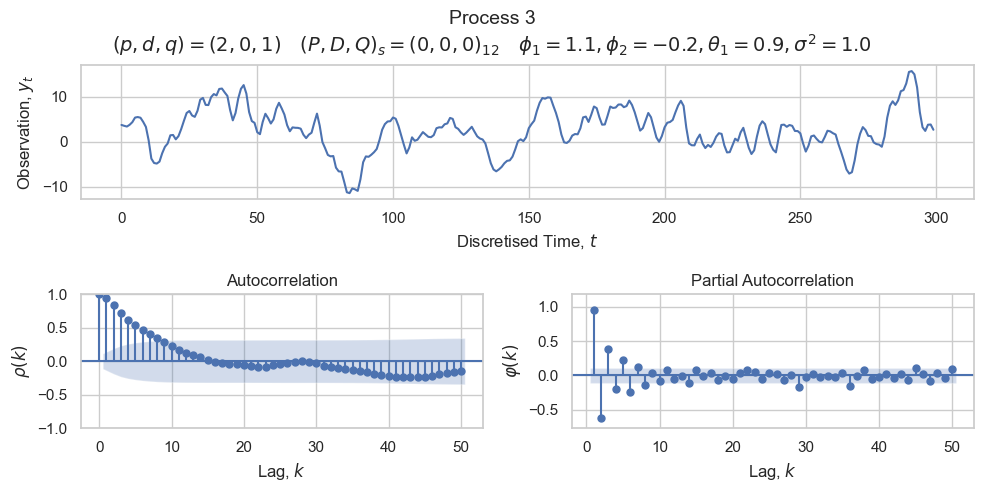

In [174]:
## 3.3
make_and_plot(
    ModelParams.from_weights(phis=[1.1, -0.2], thetas=[0.9], s=12),
    n=300,
    title="Process 3",
    n_lags=50,
)